# Submodular Functions and Greedy Maximization

This Jupyter Notebook is meant to complete [this](https://adrienvdb.com/2020/11/09/submodular-functions-and-greedy-maximization/) blog article. 

In this notebook, we will achieve the following:

- Create some simple submodular functions
- Implement both the *naive* and the *greedy* algorithms to maximize submodular functions under cardinality constraint
- Re-create the examples mentioned in the blog post and run the algorithms on them
- Observe that greedy does not always gives the best solution

Let's start, first we import some useful Python packages

In [196]:
import math
import networkx as nx
import random
import time

from collections import defaultdict
from itertools import combinations, product
from matplotlib import pyplot as plt
from tqdm import trange

%matplotlib inline

## Discovering Submodular Functions

### The Hiking Example

In that example, we had the ground set being $N = \{bottle, compass, sandwich, sunglasses, jacket, shoes\}$. We could define $f$ to assign some predefined value for every subset of items as seen in the blog post. 

Here we will, give a value to each item, and we will construct $f$ as being the sum of the values of the items selected. That is, if for each $i \in N$, we assign it value $v_i$, we have that

$$f(S) = \sum_{i \in S} v_i.$$

In [2]:
# The ground set together with a value for each item
hiking_values = {'bottle': 4, 'compass': 1, 'sandwich': 4, 'sunglasses': 2, 'jacket': 3, 'shoes': 5}

# The submodular function computing the sum of value of the items selected
def f_hiking(items):
    items_values = [hiking_values[item] for item in items]
    return sum(items_values)

Let's see the output for a few possible subsets of items.

In [3]:
arg1 = {'bottle', 'sandwich'}
print('Picking the {} and the {} has value {}.'.format(*arg1, f_hiking(arg1)))

arg2 = {'sandwich', 'compass'}
print('Picking the {} and the {} has value {}.'.format(*arg2, f_hiking(arg2)))

arg3 = {'bottle', 'sandwich', 'jacket', 'sunglasses'}
print('Picking the {}, the {}, the {} and the {} has value {}.'.format(*arg3, f_hiking(arg3)))

Picking the sandwich and the bottle has value 8.
Picking the sandwich and the compass has value 5.
Picking the sandwich, the sunglasses, the bottle and the jacket has value 13.


Since the items have different values, different combinations will obviously give different values. Note also that since all the values are positive here, the more items we select, the higher the value. So selecting all items in this case would give the maximum value $f$ can take. That is, $\max_{S \subseteq V}f(S)$ is achieved for $S=\{bottle, compass, sandwich, sunglasses, jacket, shoes\}$.

Now as a little exercise, try to prove that $f$ submodular. Recall that a function $f$ is submodular if $f(A) + f(B) \geq f(A \cap B) + f(A \cup B)$ is true for all $A, B \subseteq N$. You can also verify it using Python if you prefer.


<details>
<summary><a class="btnfire small stroke">>&nbsp;&nbsp;Show proof</a></summary>
    
Let $A, B \subseteq N$. We will show that $f(A) + f(B) \geq f(A \cap B) + f(A \cup B)$. We have

$$f(A) + f(B) = \sum_{i \in A} v_i + \sum_{i \in B} v_i = \sum_{i \in A \setminus B} v_i + \sum_{i \in B \setminus A} v_i + 2\sum_{i \in A \cap B} v_i= \sum_{i \in A \cap B} v_i + \sum_{i \in A \cup B} v_i = f(A \cap B) + f(A \cup B).$$

In fact, we see here that there is equality, the function is called modular in that case.
</details>  

## Maximization of Submodular Functions under Cardinality Constraint

We now turn to the maximization of submodular function, and more specifically the case where we have a cardinality constraint. That is, given a submodular function $f$ on ground set $N$ and a cardinality constraint $k$, we aim to find

$$\max_{S \subseteq N: |S| \leq k} f(S)$$

and also (one of) the subset $S$ achieving this maximum value.

### Naive Maximization

Let's first implement the naive maximization. For that, we basically need to try all possible subsets $S$ of the ground set $N$, with here the restriction that the size of $S$ must be smaller than or equal to $k$. In Python, there is the very useful `combinations` function from the `itertools` package in order for us to get all possible combinations. Given a sequence `seq` and a number `size`, it returns all possible combinations of size `size` of the elements of `seq.`

In [174]:
def naive_maximization_under_cc(submodular_function, ground_set, k=5):
    """Performs the naive maximization under cardinality constraint k given a
    set function and its ground set"""
    
    # Variable that will hold the maximum value of f
    max_value = -float('inf')
    
    # Variable that will contain (one of) the subset S achieving the maximum
    max_subset = None
    
    # Try every possible size S can take, from 1 to k
    for size in trange(1, k + 1, desc='Processing subsets of size'):
        
        # For each possible combinations of that size
        for S in combinations(ground_set, size):
            
            # Compute the value of the set function for this subset
            f_value = submodular_function(S)
    
            # If the value is bigger than the current maximum one, update the max
            if f_value > max_value:
                max_value = f_value
                max_subset = S
    
    # Return the max value and the subset achieving it
    return max_value, set(max_subset)

As a mini-example, let's run the algorithm on our hiking example, with $k=6$ (so basically no cardinality constraint since $|N|=6$ in this case). We already know that the maximum value is achieved when we pick all the items, so let's verify it!

In [192]:
max_value_hiking, max_set_hiking = naive_maximization_under_cc(f_hiking, hiking_values.keys(), k=len(hiking_values))

print('The best subset to pick is composed of {} and has value {}.'.format(set(max_set_hiking), max_value_hiking))

Processing subsets of size: 100%|██████████| 6/6 [00:00<00:00, 5025.12it/s]

The best subset to pick is composed of {'bottle', 'compass', 'sunglasses', 'shoes', 'sandwich', 'jacket'} and has value 19.


All good! Note how the naive algorithm is still fast in this case as we've seen in the blog post. Indeed, the size of the ground set is small here, so trying every possible combination is still not too costly.

### Greedy Maximization

Let's now implement the greedy algorithm for maximizing a submodular function under cardinality constraint. We recall that the pseudocode is as follows:

![title](https://adrienvdb.com/wp-content/uploads/2020/11/Screenshot-from-2020-11-05-11-11-41.png)

So the idea is to start with an empty subset $S$, and iteratively add elements from the ground set which give highest marginal contribution at each step.

In [246]:
def greedy_maximization_under_cc(submodular_function, ground_set, k=5):
    """Performs the greedy maximization under cardinality constraint k given a
    set function and its ground set"""
    
    # Variable that will hold the maximum value greedy can find
    greedy_value = 0
    
    # Variable that will contain the subset S found by greedy
    greedy_subset = set()
    
    # k times, we add a new element to our current set S
    for i in range(k):
        
        # Init some variables
        best_contribution = -float('inf')
        best_element = None
        
        # For every element not yet in our subset S
        for element in set(ground_set) - greedy_subset:
            
            # Compute the marginal contribution of the element to S
            marginal_contribution = submodular_function(greedy_subset | {element}) - greedy_value
            
            # If the marginal contribution is better then the current best, update
            if marginal_contribution > best_contribution:
                best_contribution = marginal_contribution
                best_element = element
        
        # Add the new element to the set S
        greedy_subset = greedy_subset | {best_element}
        
        # Update the current function value achieved by S
        greedy_value += best_contribution
    
    # Return what greedy found
    return greedy_value, greedy_subset

Again, we compute the result for our hiking example:

In [194]:
max_value_hiking, max_set_hiking = greedy_maximization_under_cc(f_hiking, hiking_values.keys(), k=len(hiking_values))

print('The best subset to pick is composed of {} and has value {}.'.format(set(max_set_hiking), max_value_hiking))

The best subset to pick is composed of {'sunglasses', 'bottle', 'compass', 'shoes', 'sandwich', 'jacket'} and has value 19.


Note that in the case of *modular* functions (which is the case in the hiking example), the greedy algorithm actually returns the optimal value, as we can see here. This can be proved mathematically.

## Other Examples 

We revisit now some of the examples presented in the blog post, and see how the two algorithms perform on them.

### Graph cuts

In order to work with graphs, we use the NetworkX package. Given a graph $G(V, E)$, the submodular function we will consider here is the one on ground set $N=V$, and which compute the cut size of the cut given by the selected subset of nodes of $G$. I.e., we have $f(S) = |\{(u, v) \in E: u \in S, v \in V \setminus S\}|$ for all $S \subseteq V$.

For the purpose of this example, we will work with a random graph on $|V|=20$ vertices, generated using the Barabasi-Albert procedure.

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


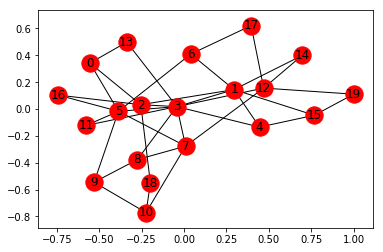

In [142]:
# Number of vertices in the graph
n_vertices = 20

# Generate the graph using the barabasi-albert procedure
G = nx.random_graphs.barabasi_albert_graph(n_vertices, 2, seed=3)

# Draw the graph
nx.draw_networkx(G, pos=nx.spring_layout(G, seed = 12))

# Define the function to compute the cut size
f_cut = lambda S: nx.cuts.cut_size(G, S)

Now looking at the graph, if we were to pick the cut defined by $S=\{6, 14, 17\}$, we see from the drawing of the graph that the cut value in this case would be 5 (upper right hand side of the figure you will find the nodes 6, 17 and 14). Let's just check this with our function.

In [143]:
S = {6, 14, 17}
print('The cut size for cut {6, 14, 17} is', f_cut(S))

The cut size for cut {6, 14, 17} is 5


This function is particular because it is submodular. Recall that submodularity of $f$ implies that for all $A, B \subseteq N$, we should have that $f(A)+f(B) \geq f(A \cap B) + f(A \cup B)$. Let us check this with a simple example, and then with various random subsets $A$ and $B$ of size 5.

In [153]:
# Check the submodular property for a simple example
A = {0, 2, 13}
B = {4, 5, 7, 8, 18}

print('The submodular property is respected since', f_cut(A) + f_cut(B), '>=', f_cut(A & B) + f_cut(A | B), 'as expected.')
print()

# Check submodular property for randomly 50 generated subsets A and B
submodular_property_check = []

for _ in range(50):
    
    # Generate random subsets A and B
    A = set(random.sample(set(range(20)), k=5))
    B = set(random.sample(set(range(20)), k=5))
    
    # Check if the submodular propery is verified and append result to list
    submodular_property_check.append(f_cut(A) + f_cut(B) >= f_cut(A & B) + f_cut(A | B))
    
print('It is', all(submodular_property_check), 'that the submodular property is respected for all the random subsets.')

The submodular property is respected since 22 >= 18 as expected.

It is True that the submodular property is respected for all the random subsets.


Now, let's use our algorithm and find some maximums! We first start by running the naive maximization with cardinality constraint $k=8$.

In [202]:
# Record starting time (to compute the running time)
start_time = time.time()

# Run the greedy algorithm

max_value_cut, max_set_cut = naive_maximization_under_cc(f_cut, range(len(G)), k=8)

# Get the running time of the aglorithm
duration = time.time() - start_time

print('The maximum value is {} and it took {} seconds to compute it'.format(max_value_cut, duration))

Processing subsets of size: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]

The maximum value is 30 and it took 7.791031837463379 seconds to compute it


And as comparison, we run the greedy algorithm below.

In [203]:
# Record starting time (to compute the running time)
start_time = time.time()

# Run the greedy algorithm

max_value_cut, max_set_cut = greedy_maximization_under_cc(f_cut, range(len(G)), k=8)

# Get the running time of the aglorithm
duration = time.time() - start_time

print('The maximum value is {} and it took {} seconds to compute it'.format(max_value_cut, duration))

The maximum value is 27 and it took 0.0364840030670166 seconds to compute it


We observe two things here:
   1. The value found by greedy is not the maximal one, so greedy is not always the best.
   2. Greedy is much faster than the naive method.

### Coverage

In the coverage problem, we are given a universe of elements $U$ and subsets $T_1, T_2, \dots, T_n \subseteq U$ of this universe. The submodular function we consider is defined on ground set $N=\{1, 2, \dots, n\}$ (the indices of the subsets $T_i$'s) as follows: $f(S) = |\cup_{i \in S} T_i|$ for $S \subseteq N$, that is, it counts the number of elements of $U$ we cover by taking the union of some specific subset of $T_i$'s.

As a first example, we consider $U=\{1, 2, \dots, 10000\}$. We will generate the $T_i$'s as being random subsets of $U$, with their size picked at random too. We first create the Python functions to generate all of this and to create the submodular function.

In [156]:
U = set(range(10000))

def generate_random_subset(U):
    """Function to generate a random subset of universe U"""
    
    # Pick a random size (smaller than the size of U divided
    # by 5 so that the T_i's are not too big)
    size = random.randrange(1, math.ceil((len(U) + 1) / 5))
    
    # Get a random subset of U of the specified size
    subset = random.sample(range(len(U)), size)
    
    # Return the random set
    return set(subset)

def generate_subsets(U, n):
    """Generate a sequence of random subsets of U"""
    subsets = []
    
    # Generate as many random subsets as necessary
    for _ in range(n):
        subsets.append(generate_random_subset(U))
    
    # Return the list of generated subsets
    return subsets

def f_coverage(S, all_subsets):
    """Function that computes the coverage given indices of subsets.
    The subsets are given in the argument all_subsets"""
    
    # Retrieve only the selected subsets
    selected_subsets = [all_subsets[i] for i in S]
    
    # Compute the number of elements in the union
    return len(set.union(*selected_subsets))

Finally, we generate 40 random subset of $U$. And we use the function to see how much of the universe all these elements actually cover.

We also see how much a few of these cover $U$.

In [166]:
# Generate subsets
all_subsets = generate_subsets(U, 40)

# Take all the indices (1 to 40 basically) and computes how much all our subsets cover the universe
S = set(range(40))
print('Coverage of all subsets: {} / {}'.format(f_coverage(S, all_subsets), len(U)))

# Take indices {0, 4, 8} and computes how much the corresponding subsets cover the universe
S = {0, 4, 8}
print('Coverage of subsets with indices {{0, 4, 8}}: {} / {}'.format(f_coverage(S, all_subsets), len(U)))

Coverage of all subsets: 9805 / 10000
Coverage of subsets with indices {0, 4, 8}: 2495 / 10000


I invite you to try and pick some subsets $A$ and $B$ of indices and then check that the submodularity property holds in this case too.

Now, let's use our algorithm and find some maximums! We first start by running the naive maximization with cardinality constraint $k=5$.

In [199]:
# Record starting time (to compute the running time)
start_time = time.time()

# Run the greedy algorithm
max_value_coverage, max_set_coverage = naive_maximization_under_cc(lambda S: f_coverage(S, all_subsets), range(len(all_subsets)), k=5)

# Get the running time of the aglorithm
duration = time.time() - start_time

print('The maximum value is {} and it took {} seconds to compute it'.format(max_value_coverage, duration))

Processing subsets of size: 100%|██████████| 5/5 [03:09<00:00, 37.91s/it]

The maximum value is 6200 and it took 189.56952023506165 seconds to compute it


Great, we now know the maximum value when $k=5$, but observe it took basically 3 minutes to compute it!

Greedy should definitely do better here, but will not necessarily find the best value:

In [200]:
# Record starting time (to compute the running time)
start_time = time.time()

# Run the greedy algorithm
greedy_maximization(lambda S: f_coverage(S, all_subsets), range(len(all_subsets)), k=5)

# Get the running time of the aglorithm
duration = time.time() - start_time

print('The maximum value is {} and it took {} seconds to compute it'.format(max_value_coverage, duration))

The maximum value is 6200 and it took 0.08582663536071777 seconds to compute it


Well, it was able to find the best value in that case, but note the running time, less than 0.1 seconds. It's a huge improvement compared to the naive method. That is basically the reason the field of algorithms exist. One tries to find a method to solve a problem as fast and as reliably as possible.

## Going further - When greedy does not perform well

We have seen from the previous examples how the two algorithms perform. We see that there is the need to develop better algorithms! Indeed, the naive method finds the maximum value, but is extremely slow. On the other hand, greedy is extremely fast, but can sometimes give poor solutions.

If you remember, I stated an interesting theorem at the end of the blog post, which says that when maximizing a monotone submodular function with cardinality constraint $k$, we have the following. The set $S$ returned by greedy is such that $f(S) \geq (1-(1-1/k)^k)f(O) \geq (1-1/e)f(O)$, where $O$ is the optimal value we wish to find.

Well we will see below what we call a "tight" example, that is an example where the subset found by greedy is such that $f(S) = (1-(1-1/k)^k)f(O)$, so it is as worst as it can get.

### A tight example

This example is about coverage functions. Here, the universe of elements is $U = \{1, 2, \dots, k\}^n$, where $k$ is the cardinality constraint, and $n$ is some integer. So $U$ is the universe containing vectors of dimension $n$ whose coordinates can take values in $\{1, 2, \dots, k\}$.

In order to get the special case, we "craft" some specific subset from which we will need to choose later on. First, we define the sets $S_1, S_2, \dots, S_n$ as follows:

$$S_i = \{x \in U: x_i = 1\}$$ for $i \in \{1, 2, \dots, n\}$. We also define subsets $T_1, T_2, \dots, T_k$ as

$$T_j = \{x \in U: x_1 = j\}$$ for $j \in \{1, 2, \dots, k\}$.

Note that under cardinality constraint $k$, the optimal choice is to pick all the sets $T_i$'s since their union cover all the universe. However, it can be the case that greedy chooses the $k$ sets only from $S_1, S_2, \dots, S_n$, and the way they were constructed makes it that they cover only a fraction $1-(1-1/k)^k$ of the universe.

Let us implement this for the case $n=7$ and $k=6$. To generate all elements in the universe, the Python function `product` from the package `itertools` is really useful.

In [267]:
# Set the values for n and k
n = 7
k = 6

# Generate all elements of the universe
universe_tight = set(product(range(k), repeat=n))

# Generate the sets S_1, S_2, ... S_n
Ss = [{elem for elem in universe_tight if elem[i] == 1} for i in reversed(range(n))]

# Generate the sets T_1, T_2, ..., T_k
Ts = [{elem for elem in universe_tight if elem[0] == j} for j in range(k)]

# Collect all subset in one big sequence
all_subsets = Ss + Ts

As mentioned before, the optimal value $f(O)$ of $f$ is attained when we pick subsets $T_1, \dots, T_k$ (so $O=\{1, 2, \dots, k\}$) since it covers the universe. Obviously in this case, $f(O)$ is equal the size of the universe.

In [268]:
max_value_coverage_tight, _ = greedy_maximization_under_cc(lambda x: f_coverage(x, all_subsets), range(len(all_subsets)), k=k)

print('The greedy algorithm gives us f(S) =', max_value_coverage_tight)
print('Also, we have that (1-(1-1/k)**k) * f(O) =', (1-(1-1/k)**k) * len(universe_tight))

The greedy algorithm gives us f(S) = 186186
Also, we have that (1-(1-1/k)**k) * f(O) = 186186.0


So in the specific case of monotone submodular functions and maximization under cardinality constraint, this is as bad as greedy can get.

## Conclusion 

In this Jupyter Notebook, we have seen basic set functions, and in particular submodular functions. We saw how using the naive and greedy algorithms, we were able to sometimes maximize these functions while having a not too long running time.

I invite you to go further and try to define your own set function. How long does the naive algorithm take to solve your maximization problem? What about greedy? You can check also online for more advanced algorithms.

For example, when a submodular function is not monotone, one can use an algorithm called the *double greedy*, which gives not too bad results and has the advantage of being very simple to implement. You can have some explanation [here](http://people.csail.mit.edu/stefje/fall15/notes_lecture17.pdf).

## References

The notation and examples shown are greatly inspired from the lecture notes of the Advanced Algorithms class taught at EPFL in 2019-2020.